### **PulsePro** : Fitness and Nutrition Agent


### *Environment Setup*

In [11]:
# Installation
%%capture --no-stderr
%pip install -U langchain_community langchain_google_genai langchain_experimental  langgraph

In [2]:
from google.colab import userdata
gemini_api_key = userdata.get('GEMINI_API_KEY')

In [3]:
import os
os.environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Agentic_Chatbot"

In [4]:
#Initializing the LLM
from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model='gemini-1.5-flash',api_key=gemini_api_key,temprature=0.8)

### *State and Tools*

In [5]:

from pydantic import BaseModel
from langgraph.graph import MessagesState
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage , HumanMessage , RemoveMessage
from langgraph.types import Command, interrupt
# Defining State
class State(MessagesState):
  summary:str

# Creating Tools
def workout_planner (query:str):
  ''' Workout planner is a tool that will be called when a user in his query asks about any workout suggestions and some gym related
      queries , then it will provide the user some workout and exercise suggestions.
  '''

  response = llm.invoke(query)
  return response

def Calorie_counter(query:str):
  ''' Calorie counter is a tool that will provide users diet suggestions and calorie count for diets and suggest diet that is beneficial for the health'''
  response = llm.invoke(query)
  return response

tools = [workout_planner , Calorie_counter]
# Binding tools with llm
llm_with_tools = llm.bind_tools(tools)

### *NODES*

In [6]:
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import tools_condition , ToolNode
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.state import CompiledStateGraph
from langgraph.errors import NodeInterrupt
from typing import Annotated , Optional

class Specific_or_not(BaseModel):
  Specific:Annotated[bool,None,'Query is Related to the fitness and Nutrition or Not']
  Reason:Annotated[Optional[str] , None , 'Reason why the query is returned as false ']

#Creating Node
structured_llm = llm.with_structured_output(Specific_or_not)
sys_msg = SystemMessage(content='You are a gym trainer and workout planner. You have to guide the users effeciently and precisely',name='System')
def Assistant (state:State)->MessagesState:
  # # Instead of adding, create a list of messages
  # messages = [sys_msg] + state['messages']
     # Get summary if it exists
    summary = state.get("summary", "")
    sys2_msg = SystemMessage(content=f''' You are a quey validator . You have to check user's query if the user's query is related to fitness
, workout , gym , diet , calories and if the user's query is not clarified and need more details then return false otherwise true''',name='System')
    last_message = state['messages'][-1].content
    msg2 = [sys2_msg, HumanMessage(content=last_message)]
    res = structured_llm.invoke(msg2)
    if not res.Specific:
      print(f'Interrupt :{res.Reason}')
      raise NodeInterrupt(f'Reason for interruption : {res.Reason}')
    # If there is summary, then we add it
    if summary:

        # Add summary to system message
     system_message = f'''You are a fitness and diet assistant equipped with tools to provide personalized workout suggestions
        and calorie counting for diet recommendations. When a user asks questions related to fitness routines, calorie intake, or diet plans,
        you should identify the query as requiring a tool-based response. Use the appropriate tool—either the 'Workout Planner' for fitness
        suggestions or the 'Calorie Counter' for diet advice—to generate the most accurate and helpful response for the user.
        Always prioritize calling the tools to deliver precise and tailored guidance,
        ensuring the user receives the best assistance possibleSummary of conversation earlier: {summary}'''


        # Append summary to any newer messages
     messages = [SystemMessage(content=system_message)] + state["messages"]

    else:
        messages = state["messages"]


    return {'messages': [llm_with_tools.invoke(messages)]}
#Summary Node
def summarize_conversation(state: State):

    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt
    if summary:

        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )

    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = llm_with_tools.invoke(messages)

    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):

    """Return the next node to execute."""

    messages = state["messages"]

    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"

    # Otherwise we can just end
    return END
def Router(state:State):
  pass
def Human_feedback(state:State):
  pass



### *Compilation of Graph : Workflow*

In [8]:
memory: MemorySaver = MemorySaver()

workflow = StateGraph(MessagesState)
# Adding Nodes
workflow.add_node('Human_feedback',Human_feedback)
workflow.add_node('Assistant',Assistant)
workflow.add_node('Router',Router)
workflow.add_node('tools',ToolNode(tools))
workflow.add_node('summarize_conversation',summarize_conversation)
#Adding Edges
workflow.add_edge(START,'Human_feedback')
workflow.add_edge('Human_feedback','Assistant')
workflow.add_conditional_edges(
     "Assistant",
     #If the response from the assistant is a tool call then it will go the tool and if not it will go to the Router
     tools_condition,
     {
         "tools":"tools",
         "__end__":"Router"
     }
)
workflow.add_edge('tools','Assistant')
# workflow.add_edge('Assistant','Router')
workflow.add_conditional_edges(
    'Router',
    should_continue,
    {
        "summarize_conversation": "summarize_conversation",
        "__end__": END
    }
)
workflow.add_edge('summarize_conversation',END)
graph  = workflow.compile(checkpointer=memory,interrupt_before=['Human_feedback'])


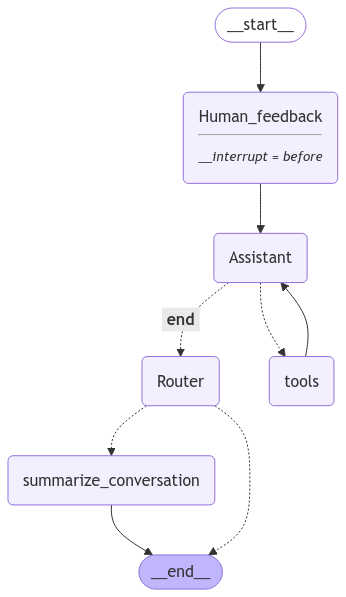

In [9]:
from IPython.display import Image , display
display(Image(graph.get_graph().draw_mermaid_png()))

### *Execution*

In [10]:
initial_input= {'messages':'Hi ! What is best exercise for calorie burn'}
config1 = {"configurable": {"thread_id": "1"}}

for event in graph.stream(initial_input, config1, stream_mode="values"):
    event["messages"][-1].pretty_print()
user_interrupt = input('Hi ! Human , If you want to update the state type in or just type NO and I will continue with the previous state')
if user_interrupt.lower()=='no':
  for event in graph.stream(None, config1, stream_mode="values"):
    event["messages"][-1].pretty_print()
else:
  graph.update_state(config1, {"messages": user_interrupt}, as_node="Human_feedback")
  for event in graph.stream(None, config1, stream_mode="values"):
    event["messages"][-1].pretty_print()


# Handling the Dynamic Interrupt using Forking
state= graph.get_state(config1)
if len(state.tasks) != 0:
  update=input('Your Query is not clear , Rewrite your query and make things clear and related to the services and be more specific  : ')
  all_states = [s for s in graph.get_state_history(config1)]
  fork = all_states[-2]
  fork_config = graph.update_state(
    fork.config,
    {"messages": [HumanMessage(content=update,
                               id=fork.values["messages"][0].id)]},
    )
  for event in graph.stream(None, fork_config, stream_mode="values"):
    event['messages'][-1].pretty_print()


================================ Human Message =================================

Hi ! What is best exercise for calorie burn
Hi ! Human , If you want to update the state type in or just type NO and I will continue with the previous stateno
================================ Human Message =================================

Hi ! What is best exercise for calorie burn
Interrupt :What is best exercise for calorie burn
Your Query is not clear , Rewrite your query and make things clear and related to the services and be more specific  : how many calories will burn if i run for 10 minutes (light jogging)
================================ Human Message =================================

how many calories will burn if i run for 10 minutes (light jogging)
================================== Ai Message ==================================
Tool Calls:
  Calorie_counter (0a7f3780-7bdc-4932-8be6-96562d670d8d)
 Call ID: 0a7f3780-7bdc-4932-8be6-96562d670d8d
  Args:
    query: how many calories will burn if